In [60]:
import numpy as np
import matplotlib.pyplot as plt

from quant_rotor.core.dense.hamiltonian import hamiltonian_dense
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense
from quant_rotor.models.dense.support_ham import write_matrix_elements, basis_m_to_p_matrix_conversion, create_inverse_index_map, m_to_p

from quant_rotor.models.dense.density_matrix import density_matrix_1

from quant_rotor.core.dense.de_solve_one_thermal import integration_scheme
from quant_rotor.core.dense.de_solve_one_thermal_dense import integration_scheme as integration_scheme_fast

from quant_rotor.models.dense.stat_mech_thermo import U as U_stat

In [61]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=np.inf)

# Make the double grouped Hamiltonian

In [3]:
state = 3
state_2 = state**2
site = 6
site_2 = site // 2

g = 1

In [4]:
def V_double(states: int, V: np.ndarray, periodic: bool, sites: int=4) -> np.ndarray:

    # Create a matrix of the shape of Potential energy Hamiltonian filled with zeros.
    V_H = np.zeros((states**sites, states**sites), dtype=complex)

    if periodic:
        x = sites - 1
    else:
        x = 1
    # With x defining the first site of two-body interaction, we define the second dynamically.
    y = (x+1) % sites

    # Define the total number of elements in the matrix operator, which represent the left, right, and center sites that are not interacting
    # by n_lambda, n_mu, n_nu, respectively.
    n_lambda = states**(x % (sites-1))
    n_mu = states**((sites - y - 1) % (sites - 1))
    n_nu = states**(np.abs(y - x) - 1)

    # Iterate through all elements of the Potential energy matrix operator.
    for q in range(states):
        for q_prime in range(states):
            for p in range(states):
                for p_prime in range(states):

                    # Calculate the flattened indices of the associated element.
                    row = p * states + q
                    col = p_prime * states + q_prime
                    val = V[row, col]

                    # Check if element is non zero.
                    if val == 0:
                        continue  # skip writing 0s

                    for Lambda in range(int(n_lambda)):
                        for mu in range(int(n_mu)):
                            for nu in range(int(n_nu)):

                                # Calculate the indices in the hamiltonian.
                                i = mu + q*n_mu + nu*states*n_mu + p*n_nu*n_mu*states + Lambda*n_nu*n_mu*states**2
                                j = mu + q_prime*n_mu + nu*states*n_mu + p_prime*n_nu*n_mu*states + Lambda*n_nu*n_mu*states**2

                                # Assign a values to associated.
                                V_H[i, j] += val
    return V_H

In [5]:
def H_potential_double(states: int, sites: int, V: np.ndarray, g_val: float, periodic: bool, Double: bool) -> np.ndarray:

    # Create a matrix of the shape of Potential energy Hamiltonian filled with zeros.
    V_H = np.zeros((states**sites, states**sites), dtype=complex)

    if periodic:
        site_range = sites
    else:
        site_range = sites-1

    if Double:
        V_2 = V_double(int(np.sqrt(states)), V, False)
    else:
        V_2 = V

    for x in range(site_range):

        if Double:
            if periodic:
                if (x == site - 1):
                    V_2 = V_double(int(np.sqrt(states)), V, True)
        # With x defining the first site of two-body interaction, we define the second dynamically.
        y = (x+1) % sites

        # Define the total number of elements in the matrix operator, which represent the left, right, and center sites that are not interacting
        # by n_lambda, n_mu, n_nu, respectively.
        n_lambda = states**(x % (sites-1))
        n_mu = states**((sites - y - 1) % (sites - 1))
        n_nu = states**(np.abs(y - x) - 1)

        # Iterate through all elements of the Potential energy matrix operator.
        for q in range(states):
            for q_prime in range(states):
                for p in range(states):
                    for p_prime in range(states):

                        # Calculate the flattened indices of the associated element.
                        row = p * states + q
                        col = p_prime * states + q_prime
                        val = V_2[row, col]

                        # Check if element is non zero.
                        if val == 0:
                            continue  # skip writing 0s

                        for Lambda in range(int(n_lambda)):
                            for mu in range(int(n_mu)):
                                for nu in range(int(n_nu)):

                                    # Calculate the indices in the hamiltonian.
                                    i = mu + q*n_mu + nu*states*n_mu + p*n_nu*n_mu*states + Lambda*n_nu*n_mu*states**2
                                    j = mu + q_prime*n_mu + nu*states*n_mu + p_prime*n_nu*n_mu*states + Lambda*n_nu*n_mu*states**2

                                    # Assign a values to associated.
                                    V_H[i, j] += val * g_val
    return V_H

## Check Periodic

In [6]:
H_1, K_1, V_1 = hamiltonian_dense(state, site, g)

K_2, _, _ = hamiltonian_dense(state, 2, g, periodic=False)
H_2, K_2, V_2 = hamiltonian_dense(state_2, site_2, g, Double=True, Import=True, K_import=K_2, V_import=V_1)

ValueError: too many values to unpack (expected 3)

In [ ]:
eig_val_1, eig_vec_1 = np.linalg.eigh(H_1)
eig_val_2, eig_vec_2 = np.linalg.eigh(H_2)

NameError: name 'H_2' is not defined

In [ ]:
np.allclose(np.sort(eig_val_1), np.sort(eig_val_2), atol=1e-20)

NameError: name 'eig_val_2' is not defined

## Check Non-Periodic

In [ ]:
H_1, K_1, V_1 = hamiltonian_dense(state, site, g, periodic=False)

K_2, _, _ = hamiltonian_dense(state, 2, g, periodic=False)
H_2, K_2, V_2 = hamiltonian_dense(state_2, site_2, g, periodic=False, Double=True, Import=True, K_import=K_2, V_import=V_1)

In [ ]:
eig_val_1, eig_vec_1 = np.linalg.eigh(H_1)
eig_val_2, eig_vec_2 = np.linalg.eigh(H_2)

In [ ]:
np.allclose(np.sort(eig_val_1), np.sort(eig_val_2), atol=1e-20)

True

# Annalise Results

In [76]:
state = 41
state_2 = state**2
site = 4
site_2 = site // 2

g = 1
D = 0.00001

In [77]:
K_2, _, _ = hamiltonian_dense(state, 2, g, periodic=False, D=D)

eig_val_K_2, eig_vec_K_2 = np.linalg.eigh(K_2)

index = np.argmin(eig_val_K_2)
ground_state_vec = eig_vec_K_2[:, index]

# Make a one site dencity matrix associated with the ground state.
ground_state_dencity_matrix = density_matrix_1(state, 2, ground_state_vec, 0)

In [78]:
e, v = np.linalg.eigh(ground_state_dencity_matrix)

In [80]:
gama = np.arange(-np.pi/2, np.pi * 3/2 + 2*np.pi/100, 2*np.pi/100)

In [81]:
gama.shape

(101,)

In [82]:
e_plus = np.exp(1j * gama)
e_mines = np.exp(-1j * gama)

In [83]:
m = (state - 1) // 2
v = np.empty(2*m + 1, dtype=int)
v[0] = 0
v[1::2] = -np.arange(1, m+1)
v[2::2] = np.arange(1, m+1)

In [84]:
vector_in_m = np.arange(-m, m + 1)

# Create an index map vector m -> p basis.
index_map_m_to_p = np.vectorize(m_to_p)(vector_in_m)
index_maps = [index_map_m_to_p] * 2
matrix = ground_state_dencity_matrix[np.ix_(*index_maps)]

In [85]:
C_plus = np.zeros((gama.shape[0], state))
C_minus = np.zeros((gama.shape[0], state))

for i in range(state):
    C_minus[:, i] = e_mines
    C_plus[:, i] = e_plus

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_56375/2307999815.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  C_minus[:, i] = e_mines
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_56375/2307999815.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  C_plus[:, i] = e_plus


In [86]:
C_minus = C_minus * vector_in_m
C_plus = C_plus * vector_in_m

In [87]:
y_new = np.ones((gama.shape[0], gama.shape[0]), dtype=complex)

In [88]:
for p in range(state):
    for angle_1 in range(gama.shape[0]):
        for q in range(state):
            for angle_2 in range(gama.shape[0]):
                y_new[angle_1, angle_2] += matrix[q, p] * np.exp(1j * (vector_in_m[q] - vector_in_m[p]) * gama[angle_2])

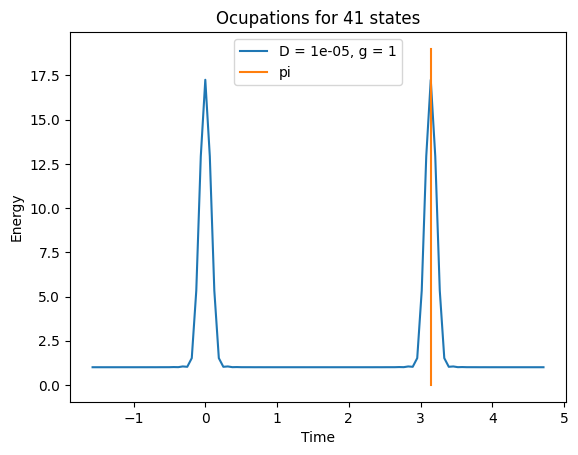

In [92]:
plt.plot(gama, np.diag(y_new), label=f"D = {D}, g = {g}")
plt.plot(np.ones((20))* np.pi, np.arange(20), label=f"pi")
plt.title(f"Ocupations for {state} states")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [49]:
np.pi/2

1.5707963267948966

In [20]:
eig_val_D, matrix_p_to_NO_full = np.linalg.eigh(ground_state_dencity_matrix)

In [21]:
eig_val_D[np.argsort(-eig_val_D)]

array([ 0.8164688454,  0.1529361999,  0.0294643988,  0.0006619471,  0.0004666712,  0.000001041 ,  0.0000008955,  0.0000000005,  0.0000000005,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          ,  0.          , -0.          ])

In [22]:
matrix_p_to_NO_full[:, np.argsort(-eig_val_D)[:2]]

array([[ 0.9984714126+0.j,  0.          -0.j],
       [-0.          +0.j,  0.7070675643+0.j],
       [-0.          +0.j,  0.7070675643+0.j],
       [ 0.0390820533+0.j,  0.          +0.j],
       [ 0.0390820533+0.j, -0.          +0.j],
       [-0.          +0.j,  0.0074471091+0.j],
       [-0.          +0.j,  0.0074471091+0.j],
       [ 0.0001103859+0.j,  0.          +0.j],
       [ 0.0001103859+0.j, -0.          +0.j],
       [-0.          +0.j,  0.0000093644+0.j],
       [-0.          +0.j,  0.0000093644+0.j],
       [ 0.000000063 +0.j, -0.          +0.j],
       [ 0.000000063 +0.j, -0.          +0.j],
       [-0.          +0.j,  0.000000003 +0.j],
       [-0.          +0.j,  0.000000003 +0.j],
       [ 0.          +0.j, -0.          +0.j],
       [ 0.          +0.j, -0.          +0.j],
       [-0.          +0.j,  0.          +0.j],
       [-0.          +0.j,  0.          +0.j],
       [ 0.          +0.j, -0.          +0.j],
       [ 0.          +0.j,  0.          +0.j]])

In [ ]:
_, V = write_matrix_elements((state - 1) // 2)

V_tensor = V.reshape(state, state, state, state)
V_in_p = basis_m_to_p_matrix_conversion(V_tensor, state)
V_in_p = V_in_p.reshape(state**2, state**2) * g

H_2, K_2, V_2_non_per, V_2_per = hamiltonian_dense(state_2, site_2, g, periodic=True, Double=True, Import=True, K_import=K_2, V_import=V_in_p)

In [ ]:
H_1, K_1, V_1 = hamiltonian_dense(state, site, g, periodic=False)

In [ ]:
eig_val_1, _ = np.linalg.eigh(H_1)
eig_val_2, eig_vec_2 = np.linalg.eigh(H_2)

In [ ]:
eig_val_K_2, eig_vec_K_2 = np.linalg.eigh(K_2)

In [ ]:
eig_val_K_2_NO, eig_vec_K_2_NO = np.linalg.eigh(K_2_NO)

In [ ]:
eig_val_K_2

array([-1.3248 , -0.94524,  0.20199,  1.83477,  2.0022 ,  2.0022 ,  2.00269,  2.9806 ,  3.36036])

In [ ]:
eig_vec_K_2

array([[ 0.92328+0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j, -0.38412+0.j],
       [-0.     +0.j, -0.5    +0.j,  0.5    +0.j,  0.5    +0.j,  0.5    +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j],
       [ 0.     +0.j,  0.5    +0.j,  0.5    +0.j,  0.5    +0.j, -0.5    +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j],
       [-0.     +0.j, -0.5    +0.j, -0.5    +0.j,  0.5    +0.j, -0.5    +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j],
       [-0.25767+0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j,  0.12716+0.j, -0.50289+0.j, -0.53003+0.j, -0.61936+0.j],
       [ 0.08589+0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j, -0.404  +0.j,  0.42192+0.j, -0.78024+0.j,  0.20645+0.j],
       [ 0.     +0.j,  0.5    +0.j, -0.5    +0.j,  0.5    +0.j,  0.5    +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j],
       [ 0.08589+0.j, -0.     +0.j,  0.     +0.j,  0.  

In [ ]:
eig_val_2

array([-2.02915, -1.9357 , -0.74929, -0.16753,  0.13364,  0.23205,  0.23205,  0.36786,  0.36786,  0.76121,  0.76121,  0.79531,  0.95022,  1.04473,  1.58137,  1.58137,  1.58137,  1.5903 ,  1.69164,  1.71861,  1.72158,  1.72158,  2.     ,  2.     ,  2.     ,  2.     ,  2.     ,  2.     ,  2.     ,  2.07074,  2.07074,  2.1    ,  2.17389,  2.17389,  2.27842,  2.37994,  2.38765,  2.51895,  2.55   ,  2.72117,  2.83293,  2.95157,  2.95157,  3.     ,  3.     ,  3.     ,  3.     ,  3.     ,  3.     ,  3.     ,  3.     ,  3.09442,  3.27927,  3.36412,  3.45   ,  3.9    ,  4.     ,  4.     ,  4.     ,  4.     ,  4.     ,  4.09563,  4.16804,  4.16804,  4.199  ,  4.199  ,  4.26173,  4.27172,  4.41863,  4.41863,  4.41863,  4.59405,  4.59405,  4.75256,  4.75998,  4.75998,  4.77136,  4.97141,  5.07312,  5.9168 ,  5.98601])

In [ ]:
eig_vec_2

array([[-0.37539+0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j, -0.1899 +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j,  0.77976+0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.15112+0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j,  0.13823+0.j,  0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j, -0.     +0.j, -0.     +0.j,  0.     +0.j

In [ ]:
print(eig_vec_2[:, np.argmin(eig_val_2)].real)

print(np.argsort(eig_val_2))

[-0.37539  0.      -0.       0.       0.20968 -0.13612 -0.      -0.13612  0.20968  0.       0.15087 -0.18678  0.20968 -0.       0.      -0.13612  0.      -0.      -0.      -0.18678  0.15087 -0.13612  0.      -0.       0.20968 -0.       0.       0.       0.20968 -0.13612  0.15087 -0.       0.      -0.18678  0.      -0.       0.20968 -0.       0.      -0.      -0.15281  0.07507  0.       0.07507 -0.09294 -0.13612  0.      -0.       0.       0.07507 -0.03307 -0.      -0.09294  0.07507 -0.      -0.13612  0.20968 -0.18678  0.      -0.       0.15087 -0.       0.      -0.13612  0.      -0.       0.       0.07507 -0.09294 -0.      -0.03307  0.07507  0.20968 -0.       0.      -0.      -0.09294  0.07507  0.       0.07507 -0.15281]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]


In [ ]:
D = density_matrix_1(state_2, site_2, eig_vec_2[np.argmin(eig_val_2)], 0)

In [ ]:
D.shape

(9, 9)

In [ ]:
eig_val_D, eig_vec_D = np.linalg.eigh(D)

In [ ]:
-np.sort(-eig_val_D)

array([ 0.60803,  0.21053,  0.13949,  0.04195,  0.     ,  0.     ,  0.     , -0.     , -0.     ])

In [ ]:
eig_vec_D[np.argsort(-eig_val_D)].real

array([[ 0.     ,  0.     ,  0.     , -0.42353, -0.08669, -0.72457,  0.53672,  0.     ,  0.00511],
       [-0.19237, -0.17925,  0.95484,  0.05538, -0.02268, -0.08551, -0.07587, -0.     ,  0.04999],
       [-0.82106,  0.01826, -0.09942, -0.29239,  0.11012,  0.35016,  0.25816,  0.     ,  0.16959],
       [ 0.00047, -0.98285, -0.18441, -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ],
       [-0.49693,  0.03923, -0.21036,  0.39815, -0.15714, -0.55264, -0.45814, -0.     ,  0.09352],
       [-0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ,  1.     , -0.     ],
       [-0.     ,  0.     , -0.     ,  0.20013,  0.96024, -0.18326,  0.06562, -0.     ,  0.00003],
       [-0.     , -0.     , -0.     ,  0.71394, -0.17771,  0.076  ,  0.63515,  0.     ,  0.22251],
       [-0.20471, -0.0023 ,  0.01174,  0.15418, -0.03889,  0.01743,  0.14799, -0.     , -0.95418]])

In [ ]:
beta, energy, t_1_max, t_2_max  = integration_scheme(site_2, state_2, t_init=0,t_final=100,nof_points=100000, Import=True,  double=True, K_import=K_2, V_import=V_2_non_per.reshape(state_2, state_2, state_2, state_2), v_full_per=V_2_per.reshape(state_2, state_2, state_2, state_2))

KeyboardInterrupt: 

In [ ]:
# beta, energy, t_1_max, t_2_max  = integration_scheme(site_2, state_2, t_init=0,t_final=100,nof_points=100000, Import=True, K_import=K_2, V_import=V_2_non_per.reshape(state_2, state_2, state_2, state_2), periodic=False)

In [ ]:
beta_s, energy_s, t_1_max_s, t_2_max_s  = integration_scheme(site, state, g, t_init=0,t_final=100,nof_points=100000, periodic=True)

In [ ]:
ED_U_val_1 = np.array([U_stat(eig_val_1, x) for x in beta])
ED_U_val_2 = np.array([U_stat(eig_val_2, x) for x in beta])

In [ ]:
np.allclose(np.sort(eig_val_1), np.sort(eig_val_2), atol=1e-20)

False

In [ ]:
b = 25

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


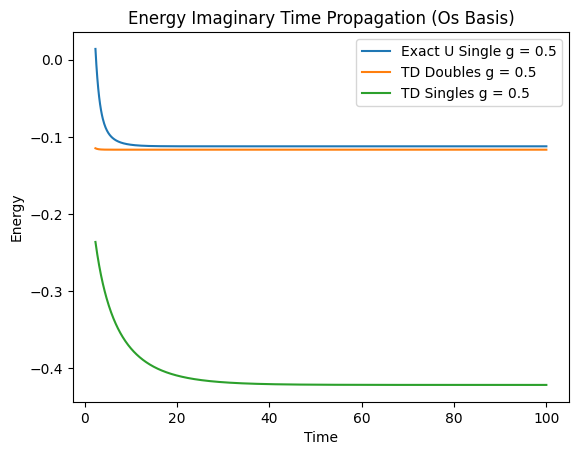

In [ ]:
plt.plot(beta[b:], ED_U_val_1[b:]/site, label=f"Exact U Single g = {g}")
plt.plot(beta[b:], -energy[b:]/site, label=f"TD Doubles g = {g}")
plt.plot(beta_s[b:], -energy_s[b:]/site, label=f"TD Singles g = {g}")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [ ]:
ED_U_val_1[-1] + energy[-1]

np.complex128(0.017466130304826744+0j)

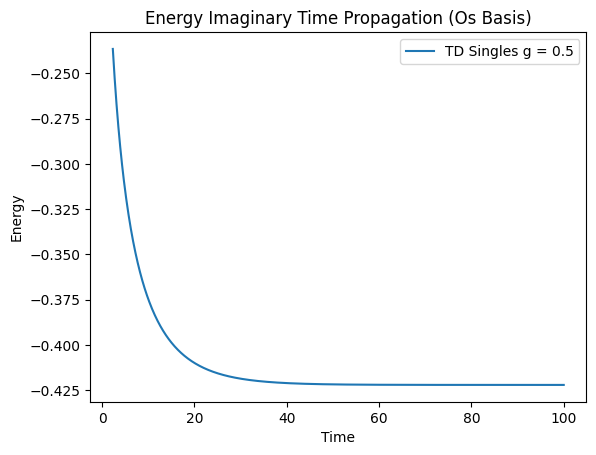

In [ ]:
# plt.plot(beta[b:], ED_U_val_1[b:]/site, label=f"Exact U Single g = {g}")
# plt.plot(beta[b:], -energy[b:]/site, label=f"TD Doubles g = {g}")
plt.plot(beta_s[b:], -energy_s[b:]/site, label=f"TD Singles g = {g}")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

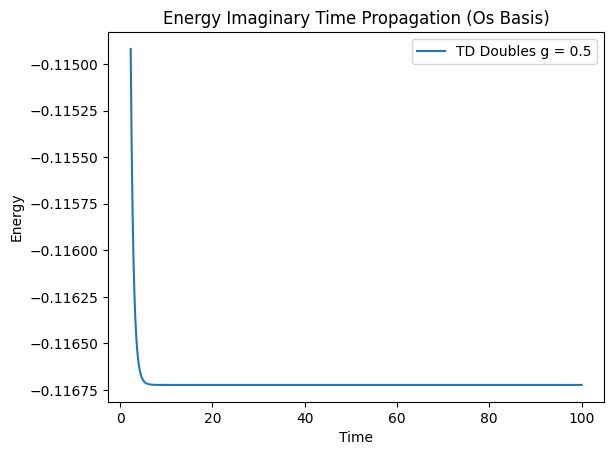

In [ ]:
plt.plot(beta[b:], -energy[b:]/site, label=f"TD Doubles g = {g}")
# plt.plot(beta_s[b:], -energy_s[b:]/site, label=f"TD Singles g = {g}")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

In [ ]:
t_1_max_vec_doulbe = []
energy_vec_doulbe = []
beta_vec_doulbe = []
ED_U_vec_doulbe = []

t_1_max_vec = []
energy_vec = []
beta_vec = []
ED_U_vec = []

g_array = np.array([0, 0.1, 0.2, 0.3, 0.5, 0.7])

In [ ]:
for g_index, g in enumerate(g_array):

    K_2, _, _ = hamiltonian_dense(state, 2, g, periodic=False)

    _, V = write_matrix_elements((state - 1) // 2)
    V_tensor = V.reshape(state, state, state, state)
    V_in_p = basis_m_to_p_matrix_conversion(V_tensor, state)
    V_in_p = V_in_p.reshape(state**2, state**2) * g

    H_2, K_2, V_2 = hamiltonian_dense(state_2, site_2, g, periodic=False, Double=True, Import=True, K_import=K_2, V_import=V_in_p)

    eig_val_ED_doulbe, _ = np.linalg.eigh(H_2)

    beta_doulbe, energy_doulbe, t_1_max_doulbe, t_2_max_doulbe = integration_scheme(site_2, state_2, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_2, V_import=V_2.reshape(state_2, state_2, state_2, state_2), periodic=False)

    ED_U_val_doulbe = np.array([U_stat(eig_val_ED_doulbe, x) for x in beta_doulbe])

    energy_vec_doulbe.append(energy_doulbe)
    ED_U_vec_doulbe.append(ED_U_val_doulbe)
    beta_vec_doulbe.append(beta_doulbe)

In [ ]:
for g_index, g in enumerate(g_array):

    H, _, _ = hamiltonian_dense(state, site, g, periodic=False)

    eig_val_ED, _ = np.linalg.eigh(H)

    beta, energy, t_1_max, t_2_max = integration_scheme(site, state, g, t_init=0,t_final=10,nof_points=100000, periodic=False)

    ED_U_val = np.array([U_stat(eig_val_ED, x) for x in beta])

    energy_vec.append(energy)
    ED_U_vec.append(ED_U_val)
    beta_vec.append(beta)

In [ ]:
colours = ["blue", "green", "red", "black", "orange", "purple"]

d = 20
Full_ED = False
Full_TD = False

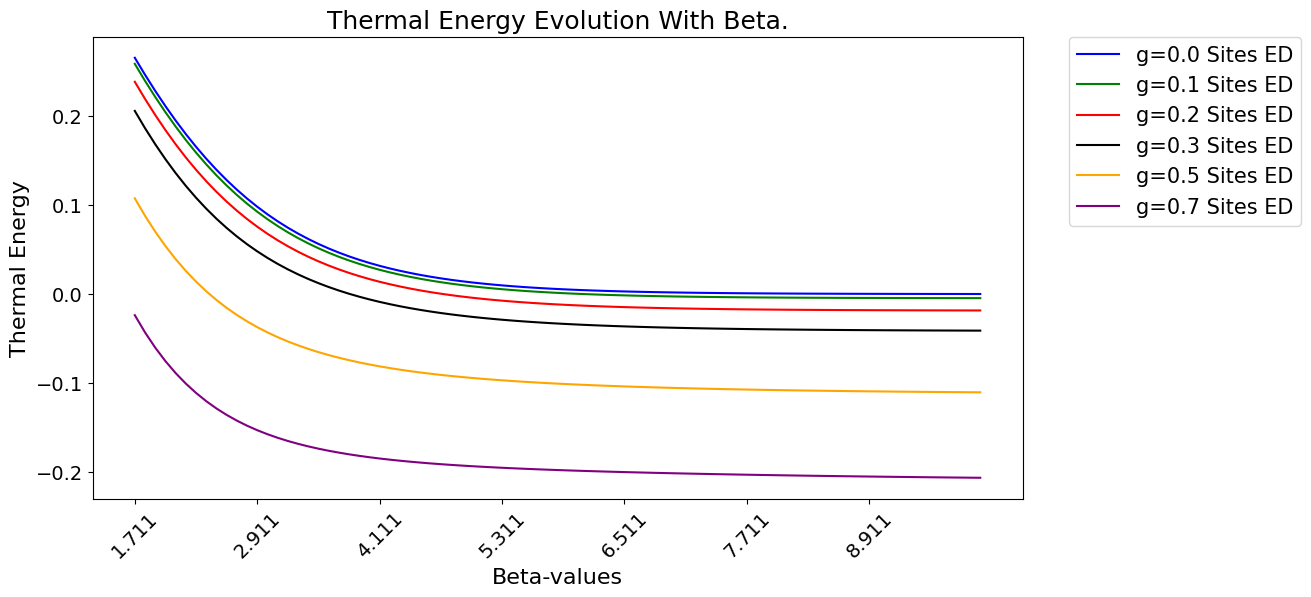

In [ ]:
plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 15,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for g_index, g in enumerate(g_array):
    # if Full_TD:
    #     plt.plot(beta_vec[g_index], -energy_vec[g_index]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    # else:
    #     plt.plot(beta_vec[g_index][d:], -energy_vec[g_index][d:]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])

    if Full_ED:
        plt.plot(beta_vec[g_index], ED_U_vec[g_index]/site, label=f"g={g} Sites ED",  color=colours[g_index])
    else:
        plt.plot(beta_vec[g_index][d:], ED_U_vec[g_index][d:]/site, label=f"g={g} Sites ED",  color=colours[g_index])
if Full_TD:
    plt.xticks(beta_vec[g_index][::12], rotation=45)
else:
    plt.xticks(beta_vec[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend(
    loc='upper left',             # position relative to the bounding box
    bbox_to_anchor=(1.05, 1),     # (x, y) coordinate for legend anchor
    borderaxespad=0.
)
plt.show()

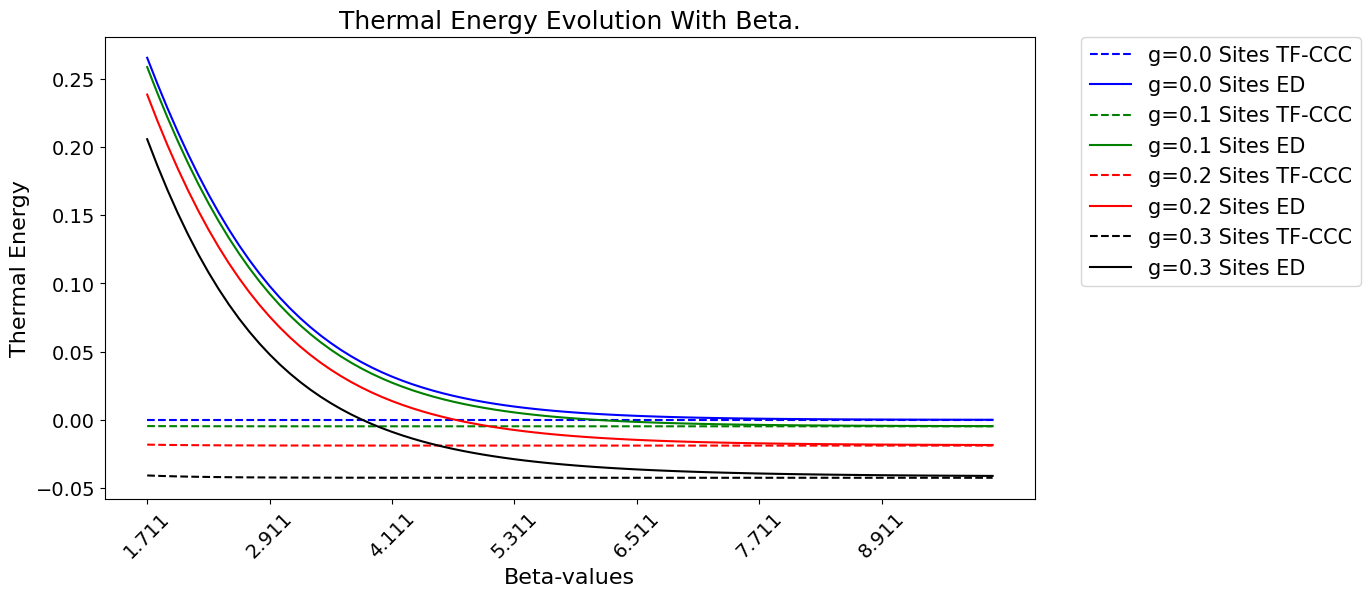

In [ ]:
plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 15,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

n = 4

for g_index, g in enumerate(g_array[:n]):
    if Full_TD:
        plt.plot(beta_vec_doulbe[g_index], -energy_vec_doulbe[g_index]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
    else:
        plt.plot(beta_vec_doulbe[g_index][d:], -energy_vec_doulbe[g_index][d:]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])

    if Full_ED:
        plt.plot(beta_vec_doulbe[g_index], ED_U_vec_doulbe[g_index]/site, label=f"g={g} Sites ED",  color=colours[g_index])
    else:
        plt.plot(beta_vec_doulbe[g_index][d:], ED_U_vec_doulbe[g_index][d:]/site, label=f"g={g} Sites ED",  color=colours[g_index])
if Full_TD:
    plt.xticks(beta_vec_doulbe[g_index][::12], rotation=45)
else:
    plt.xticks(beta_vec_doulbe[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend(
    loc='upper left',             # position relative to the bounding box
    bbox_to_anchor=(1.05, 1),     # (x, y) coordinate for legend anchor
    borderaxespad=0.
)
plt.show()

In [ ]:
g_index = 1
g =g_array[g_index]

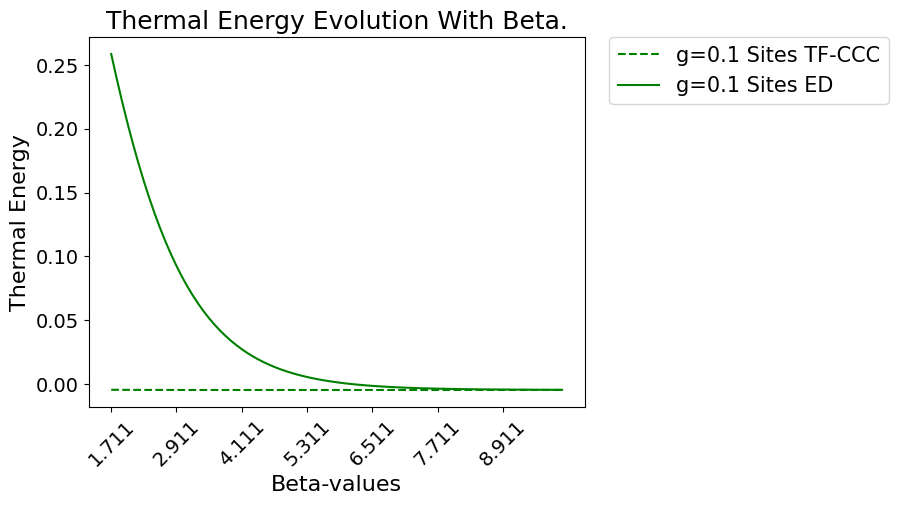

In [ ]:
if Full_TD:
    plt.plot(beta_vec_doulbe[g_index], -energy_vec_doulbe[g_index]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])
else:
    plt.plot(beta_vec_doulbe[g_index][d:], -energy_vec_doulbe[g_index][d:]/site, label=f"g={g} Sites TF-CCC", linestyle='--', color=colours[g_index])

if Full_ED:
    plt.plot(beta_vec_doulbe[g_index], ED_U_vec_doulbe[g_index]/site, label=f"g={g} Sites ED",  color=colours[g_index])
else:
    plt.plot(beta_vec_doulbe[g_index][d:], ED_U_vec_doulbe[g_index][d:]/site, label=f"g={g} Sites ED",  color=colours[g_index])
if Full_TD:
    plt.xticks(beta_vec_doulbe[g_index][::12], rotation=45)
else:
    plt.xticks(beta_vec_doulbe[g_index][d:][::12], rotation=45)
plt.xlabel("Beta-values")
plt.ylabel("Thermal Energy")
plt.title("Thermal Energy Evolution With Beta.", fontsize=18)
plt.legend(
    loc='upper left',             # position relative to the bounding box
    bbox_to_anchor=(1.05, 1),     # (x, y) coordinate for legend anchor
    borderaxespad=0.
)
plt.show()